In [13]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as sk
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.ensemble as ensemble
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_validate, KFold
from tensorflow.keras.utils import to_categorical

In [2]:
# Specify the file path
file_path = "../data/all_combined.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, low_memory=False)

# Display the DataFrame
df.head()

,ts,timestamp,frame,face_id,confidence_x,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,...,local_orientation_per_joint_32_0,local_orientation_per_joint_32_1,local_orientation_per_joint_32_2,local_orientation_per_joint_32_3,local_orientation_per_joint_33_0,local_orientation_per_joint_33_1,local_orientation_per_joint_33_2,local_orientation_per_joint_33_3,confused,help
0,0.000,0.000,1,0,0.93,1,0.031509,0.614271,-0.788466,-0.160313,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.034,0.033,2,0,0.93,1,0.041459,0.636975,-0.769769,-0.163212,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.067,0.067,3,0,0.93,1,0.037858,0.643682,-0.764356,-0.180362,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.100,0.100,4,0,0.93,1,0.016017,0.650600,-0.759252,-0.171488,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.134,0.133,5,0,0.93,1,0.010808,0.662422,-0.749053,-0.180399,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
df["body_tracking_error"]

0         False
1         False
2         False
3         False
4         False
          ...  
585909    False
585910    False
585911    False
585912    False
585913    False
Name: body_tracking_error, Length: 585914, dtype: object

In [18]:
# Clean the dat

# Declare label
label_confused = 'confused'
label_help = 'help'
label_both = 'both'
label_neither = 'neither'
label_either = 'either' # Help means you are confused and need help

labels = [label_confused, label_help, label_both, label_neither, label_either]

def clean(df):
    cols = ['body_tracking_error', 'confused', 'help']
    df = df.copy()

    # Define the patterns to filter out for body34
    patterns_to_remove_body34 = [
    r'keypoint_1[8-9]_.*',  # Matches keypoint_18_* and keypoint_19_*
    r'keypoint_2[0-5]_.*', # Matches keypoint_20_* to keypoint_29_*
    r'keypoint_3[2-3]_.*', # Matches keypoint_32_* to keypoint_33_*
    r'keypoint_confidence_1[8-9]',  # Matches keypoint_confidence_18 and keypoint_confidence_19
    r'keypoint_confidence_2[0-5]',  # Matches keypoint_confidence_20 to keypoint_confidence_29
    r'keypoint_confidence_3[2-3]', # Matches keypoint_confidence_32 to keypoint_confidence_33
    r'local_position_per_joint_1[8-9]_.*', # Matches local_position_per_joint_18_* and local_position_per_joint_19_*
    r'local_position_per_joint_2[0-5]_.*', # Matches local_position_per_joint_20_* to local_position_per_joint_29_*
    r'local_position_per_joint_3[2-3]_.*', # Matches local_position_per_joint_32_* to local_position_per_joint_33_*
    r'local_orientation_per_joint_1[8-9]_.*', # Matches local_orientation_per_joint_18_* and local_orientation_per_joint_19_*
    r'local_orientation_per_joint_2[0-5]_.*', # Matches local_orientation_per_joint_20_* to local_orientation_per_joint_29_*
    r'local_orientation_per_joint_3[2-3]_.*'  # Matches local_orientation_per_joint_32_* to local_orientation_per_joint_33_*
    ]

    # Combine patterns into a single regex pattern
    combined_pattern = '|'.join(patterns_to_remove_body34)

    # Filter columns based on the combined pattern
    filtered_columns = df.filter(regex=f'^((?!{combined_pattern}).)*$', axis=1)

    # Assign back to df
    df = df[filtered_columns.columns]

    # drop columns with NaN values in cols
    df = df.dropna(subset=cols)
    for col in cols:
        df[col] = df[col].replace(['False', 'True', '0.0', '1.0'], ['0', '1', '0', '1'])  # Replace string values with integers
        df[col] = df[col].astype('Int64')  # Use 'Int64' for nullable integers in pandas

    # Filter data based on confusion status
    df[label_both] = (df[label_confused] == 1) & (df[label_help] == 1)
    df[label_neither] = (df[label_confused] == 0) & (df[label_help] == 0)
    df[label_either] = (df[label_confused] == 1) | (df[label_help] == 1)
    df[label_confused] = (df[label_confused] == 1) & (df[label_help] == 0)
    df[label_help] = (df[label_help] == 1) & (df[label_confused] == 0)

    df = df[(df["body_tracking_error"] == 0)]

    #df = df.dropna()
    #return df[(df["body_tracking_error"] == 0) & (df["success"] == 1)]
    return df

def lost_metrics(df, df_filtered):
    # Lost Frames
    print("Original df: ", df.shape)
    print("Filtered df: ", df_filtered.shape)
    print("Lost Frames: ", df.shape[0] - df_filtered.shape[0])
    print()

    for label in labels:
        # Calculate the truth percentage of the total
        if label == label_neither:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(0, 0)) * 100
        else:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(1, 0)) * 100

        # Display the label and its truth percentage
        print(f'{label}: {truth_percentage:.2f}%')

        # Display the value counts for the label
        value_counts = df_filtered[label].value_counts()
        print(value_counts.to_string(), "\n")  # Converts the Series to a string to format it nicely

    try:
        # Display the shape of the DataFrame
        columns_with_nan = df_filtered.columns[df.isna().any()].tolist()

        # Calculate the number of NaN values for each column with NaNs
        nan_counts = df_filtered[columns_with_nan].isna().sum()

        # Create a bar plot for columns with NaN counts
        plt.figure(figsize=(12, 8))
        nan_counts.plot(kind='bar')
        plt.title('Number of NaN Values per Column')
        plt.xlabel('Columns')
        plt.ylabel('Number of NaN Values')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    except:
        print("No NaN values")


# Clean the data
df_filtered = clean(df)

# Display lost metrics
lost_metrics(df, df_filtered)

Original df:  (585914, 1102)
Filtered df:  (584072, 995)
Lost Frames:  1842

confused: 11.92%
confused
False    514426
True      69646 

help: 9.88%
help
False    526390
True      57682 

both: 3.59%
both
False    563079
True      20993 

neither: 78.20%
neither
True     456744
False    127328 

either: 21.80%
either
False    456744
True     127328 

No NaN values


In [19]:
# List of columns to drop
columns_to_drop = ['success', 'body_tracking_error', 'face_id', 'timestamp', 'id', 'ts', 'frame', 'frame_number'] + labels

# Dropping columns that are not needed
X = df_filtered.drop(columns=columns_to_drop)

# Create a single column for y with multi-class labels
Y = df_filtered.apply(lambda row: label_both if row[label_both] == 1 else 
                                    label_help if row[label_help] == 1 else 
                                    label_confused if row[label_confused] == 1 else 
                                    label_neither, axis=1)

# Drop any remaining non-numeric columns
X = X.select_dtypes(include=['number'])

In [20]:
# Standardize the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_data)

# Display metrics
print(f'Number of components: {pca.n_components_}')
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total variance explained: {sum(pca.explained_variance_ratio_)}')

# Create new DataFrame with PCA data
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Display the DataFrame
pca_df.head()

Number of components: 36
Explained variance ratio: [0.58023998 0.11326705 0.06598455 0.04910537 0.02239474 0.0171919
 0.01265001 0.00791969 0.00646961 0.00597876 0.00524732 0.00476233
 0.00456872 0.00435321 0.00390574 0.00364804 0.00359942 0.00346982
 0.00325909 0.00284448 0.00270086 0.00249911 0.00226203 0.00218563
 0.00211853 0.00202565 0.00198309 0.00185718 0.0018106  0.00173999
 0.00168693 0.00162792 0.00157676 0.0014829  0.0014482  0.00141829]
Total variance explained: 0.9512834807609022


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,0.905196,22.022807,5.967787,-9.983920,-2.743066,-0.331137,2.387822,0.006533,3.634107,1.689282,...,0.642396,-0.429168,0.240202,1.471243,-0.950336,3.601178,-0.057449,-0.077390,4.468377,-2.623765
1,0.628435,21.904069,6.146034,-9.961763,-2.794548,-0.431736,2.353528,-0.253332,3.462284,1.499521,...,0.119660,0.715737,0.761272,1.013514,-0.390484,2.369540,1.168825,1.349269,3.170197,-1.660461
2,0.363008,21.720311,6.006944,-10.038143,-2.744187,-0.532749,2.478289,-0.181538,3.338626,1.584639,...,0.109397,1.264817,0.962608,0.907988,-0.275277,1.823012,2.081762,1.715894,2.569391,-1.816700
3,0.456129,21.810123,6.013302,-10.077196,-2.775318,-0.520137,2.528814,-0.071368,3.164260,1.743499,...,0.090078,0.987889,0.809110,0.960566,-0.267593,1.226441,2.345325,1.580425,2.064676,-1.359385
4,0.628063,21.960765,6.088282,-10.061168,-2.785025,-0.467269,2.565323,0.031656,3.102834,1.798960,...,-0.073187,0.864694,0.765965,0.931289,-0.121594,0.939690,2.460057,1.633766,1.853949,-1.218611


In [25]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, random_state=42)
tsne_data = tsne.fit_transform(pca_data)

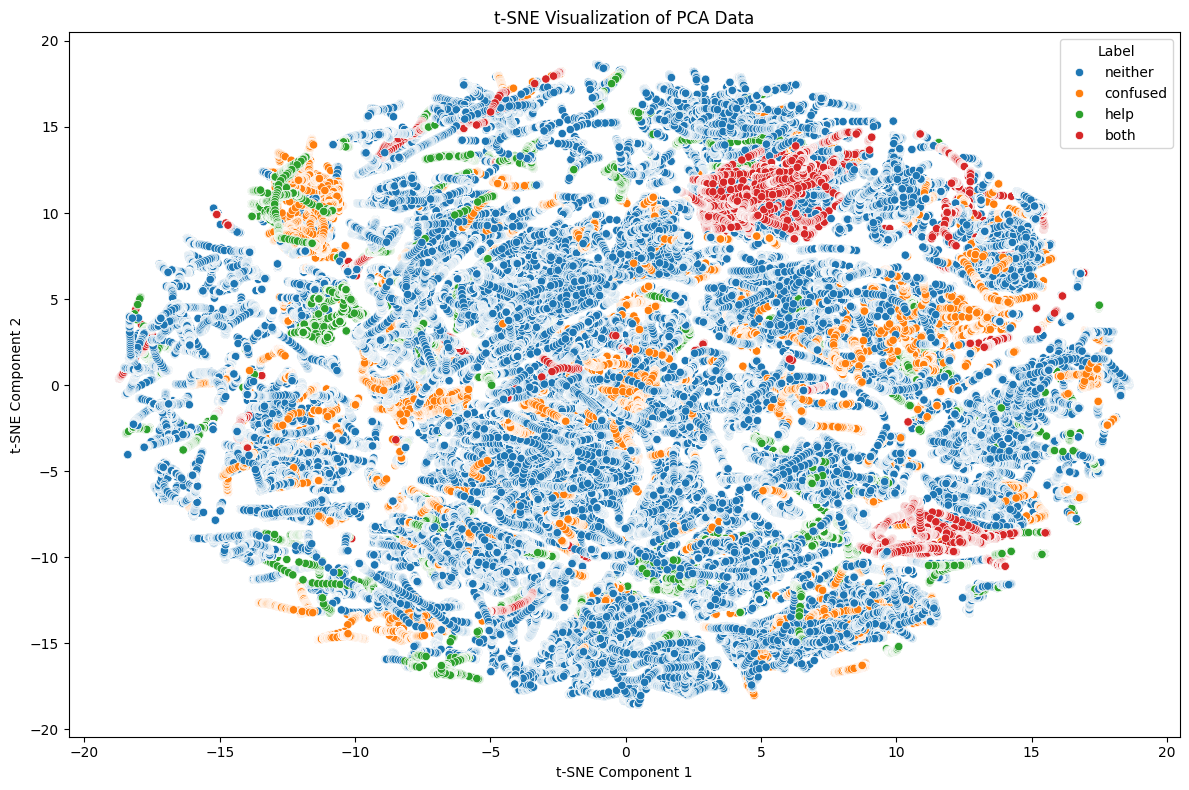

In [26]:
# Plot the t-SNE Data
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=Y, palette='tab10')
plt.title('t-SNE Visualization of PCA Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [ ]:
# Do tse based on participants and see if there is a pattern